In [1]:
# kd crossover，close < ema 8, ema 8 < ema 18, ema 18 < 38, take profit 4 atr, stop loss 3 atr
# 1651366861000
# ! conda install -c conda-forge ta --yes

In [2]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672556207000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:

sl_atr = 0.05
tp_atr = 12
kd_dir = 'Any'

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [6]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 15:14:59  1194.81  1194.37  1195.18  1193.63  1675.1834
1     2023-01-01 15:29:59  1194.36  1194.60  1194.61  1193.04  1522.0955
2     2023-01-01 15:44:59  1194.61  1195.16  1195.17  1193.80   910.7322
3     2023-01-01 15:59:59  1195.16  1195.06  1195.75  1194.61  1718.7587
4     2023-01-01 16:14:59  1195.07  1194.51  1195.90  1194.50  1266.4382
...                   ...      ...      ...      ...      ...        ...
9132  2023-04-06 19:29:59  1866.01  1865.15  1866.99  1862.59  3673.2166
9133  2023-04-06 19:44:59  1865.16  1868.73  1869.28  1864.84  4087.5879
9134  2023-04-06 19:59:59  1868.72  1868.68  1870.18  1867.34  2746.9882
9135  2023-04-06 20:14:59  1868.68  1864.41  1868.97  1863.74  5621.1281
9136  2023-04-06 20:29:59  1864.42  1861.73  1864.42  1861.47  1853.5226

[9137 rows x 6 columns]


In [7]:
df = raw_df.copy()

In [8]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [9]:
indicators(df, kd_dir)
print(df)

               Close_Time     Open    Close     High      Low     Volume  \
0     2023-01-01 15:14:59  1194.81  1194.37  1195.18  1193.63  1675.1834   
1     2023-01-01 15:29:59  1194.36  1194.60  1194.61  1193.04  1522.0955   
2     2023-01-01 15:44:59  1194.61  1195.16  1195.17  1193.80   910.7322   
3     2023-01-01 15:59:59  1195.16  1195.06  1195.75  1194.61  1718.7587   
4     2023-01-01 16:14:59  1195.07  1194.51  1195.90  1194.50  1266.4382   
...                   ...      ...      ...      ...      ...        ...   
9132  2023-04-06 19:29:59  1866.01  1865.15  1866.99  1862.59  3673.2166   
9133  2023-04-06 19:44:59  1865.16  1868.73  1869.28  1864.84  4087.5879   
9134  2023-04-06 19:59:59  1868.72  1868.68  1870.18  1867.34  2746.9882   
9135  2023-04-06 20:14:59  1868.68  1864.41  1868.97  1863.74  5621.1281   
9136  2023-04-06 20:29:59  1864.42  1861.73  1864.42  1861.47  1853.5226   

            ema_8       ema_18       ema_38       atr        rsi     slow_k  \
0       

In [10]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2023-01-01 15:14:59,1194.81,1194.37,1195.18,1193.63,1675.1834,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 15:29:59,1194.36,1194.60,1194.61,1193.04,1522.0955,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 15:44:59,1194.61,1195.16,1195.17,1193.80,910.7322,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 15:59:59,1195.16,1195.06,1195.75,1194.61,1718.7587,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 16:14:59,1195.07,1194.51,1195.90,1194.50,1266.4382,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9132,2023-04-06 19:29:59,1866.01,1865.15,1866.99,1862.59,3673.2166,1868.147591,1874.516793,1882.569048,6.199034,32.320677,36.006289,32.629470,False,False,True,True,True,False,False
9133,2023-04-06 19:44:59,1865.16,1868.73,1869.28,1864.84,4087.5879,1868.277015,1873.907657,1881.859353,6.073389,38.099922,47.264151,40.660377,False,False,False,True,True,False,False
9134,2023-04-06 19:59:59,1868.72,1868.68,1870.18,1867.34,2746.9882,1868.366567,1873.357377,1881.183489,5.842432,38.051051,47.106918,43.459119,False,False,False,True,True,False,False
9135,2023-04-06 20:14:59,1868.68,1864.41,1868.97,1863.74,5621.1281,1867.487330,1872.415548,1880.323310,5.798687,34.035840,33.679245,42.683438,True,True,True,True,True,True,False


In [12]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
open_val = entry_df['Open']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] >= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'Low'] <= take_profit):
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan


entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low      Volume  \
73    2023-01-02 09:29:59  1195.75  1196.09  1196.13  1193.00   3685.1617   
74    2023-01-02 09:44:59  1196.09  1196.03  1196.44  1195.27    953.3041   
75    2023-01-02 09:59:59  1196.03  1195.16  1196.03  1195.09    937.7949   
76    2023-01-02 10:14:59  1195.15  1196.26  1196.41  1194.46   1355.2923   
77    2023-01-02 10:29:59  1196.27  1196.20  1196.42  1195.55    608.6620   
...                   ...      ...      ...      ...      ...         ...   
9128  2023-04-06 18:29:59  1866.31  1867.43  1867.98  1862.69   6336.6351   
9129  2023-04-06 18:44:59  1867.42  1862.08  1868.00  1853.70  12887.6156   
9133  2023-04-06 19:44:59  1865.16  1868.73  1869.28  1864.84   4087.5879   
9135  2023-04-06 20:14:59  1868.68  1864.41  1868.97  1863.74   5621.1281   
9136  2023-04-06 20:29:59  1864.42  1861.73  1864.42  1861.47   1853.5226   

            ema_8       ema_18       ema_38       atr  ...     c1     c2  \

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)

for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

        
# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):
    # check if the current position is 'Stop' or 'Buy'
    if pos.loc[i, 'position'] in ['Stop', 'Buy']:
        
        # if it is, initialize a variable to store the aggregated amount
        total_amt = pos.loc[i, 'amt'] - np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Buy'
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Buy']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt -= trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()
    

# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Short':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Buy', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if position_amt_sum > max_profit:
            max_profit = position_amt_sum
            
        if position_amt_sum < max_loss:
            max_loss = position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass


# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade > 0:
        wins += 1
    elif trade < 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')



    Profit      Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  2219.54  1519.57      791.57    -18.38         13      19440.23  114.17%   

  Win_Rate  
0   24.83%  

               Close_Time     Open    Close     High      Low        ema_8  \
0     2023-01-02 09:44:59  1196.09  1196.03  1196.44  1195.27  1197.635326   
1     2023-01-02 10:14:59  1195.15  1196.26  1196.41  1194.46  1196.901864   
2     2023-01-02 10:29:59  1196.27  1196.20  1196.42  1195.55  1196.745894   
3     2023-01-02 10:44:59  1196.21  1196.61  1196.61  1196.16  1196.715695   
4     2023-01-03 08:44:59  1214.31  1216.41  1216.68  1214.31  1215.712790   
...                   ...      ...      ...      ...      ...          ...   
1401  2023-04-06 16:59:59  1881.50  1879.66  1882.41  1879.29  1882.097898   
1402  2023-04-06 17:29:59  1881.21  1883.44  1885.50  1881.01  1882.242679   
1403  2023-04-06 17:59:59  1879.85  1875.51  1880.72  1874.77  1880.331250   
1404  2023-04-06 18:44:59  1867.42

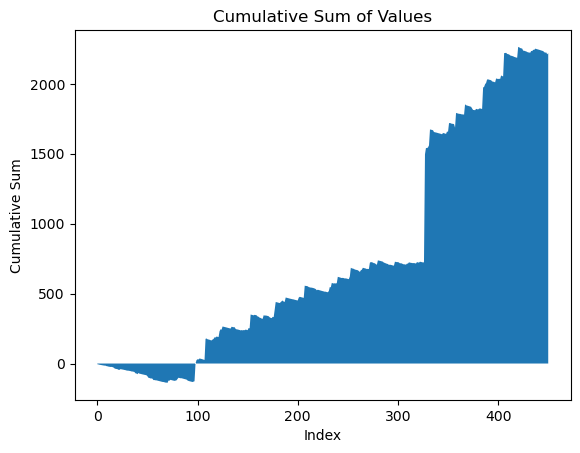

[-5.098965350000342, -6.41773755000056, -8.509559700000612, -9.82298935000073, -11.13015580000065, -12.42734690000082, -13.70612860000093, -14.985610650001028, -15.016496250001104, -18.211276500001638, -19.63334965000171, -21.754862750001898, -23.117687750002027, -24.468826700002026, -24.039530850001956, -25.374793350002005, -27.849321800001885, -34.09552300000134, -37.53394915000141, -38.88269835000149, -40.1411839500019, -44.44923625000107, -45.77737670000104, -40.32174720000121, -41.392149900000994, -42.72366330000083, -44.13726615000111, -45.91892380000084, -47.23166895000079, -49.58755380000089, -50.915406050000854, -51.174774100001216, -52.51482430000136, -53.85533440000155, -56.458613950001464, -57.01859355000144, -58.55079875000136, -60.44079020000143, -69.68170275000121, -71.15574430000113, -76.56586550000051, -67.72579375000078, -72.4368729000007, -73.91181655000085, -75.80464000000072, -77.50224605000095, -79.10086110000088, -80.74443500000085, -82.31035390000076, -83.937386

In [14]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

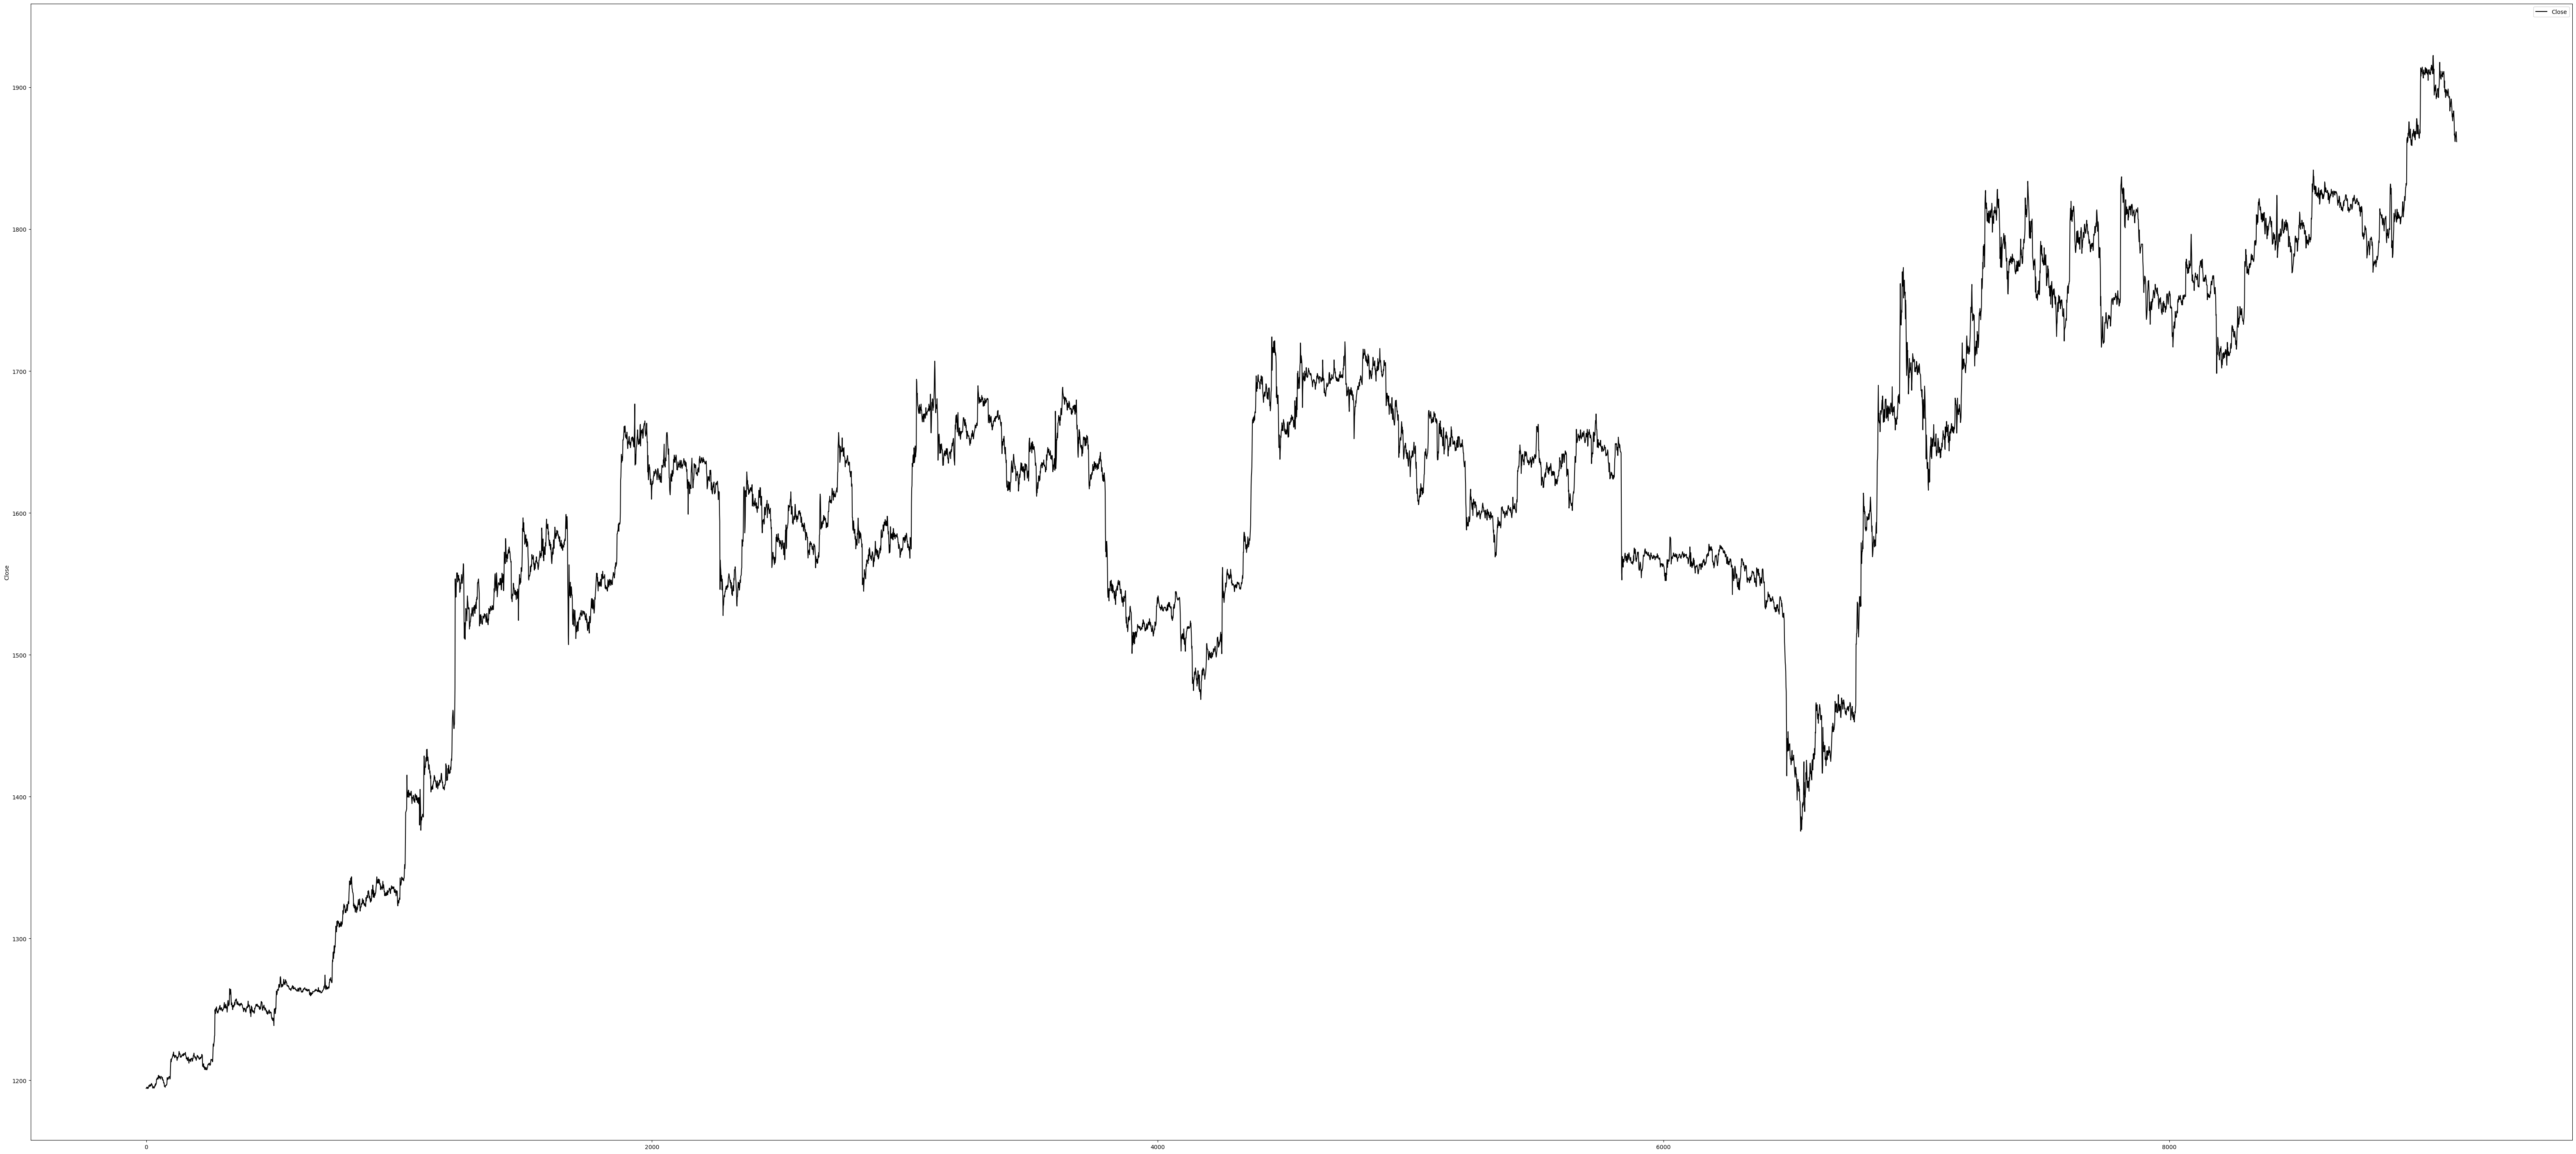

In [15]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()